<a href="https://colab.research.google.com/github/ilseslootweg/Data_mining/blob/main/RL_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reinforcement Learning 3: *Dynamic Programming*

**Assignment:** hand-in before 21/02/2022

#### **1. Frozen Lake**

*(5 x 1 points)*

The Frozen Lake environment is a 4×4 grid which contain four possible areas  — Safe (S), Frozen (F), Hole (H) and Goal (G). The agent moves around the grid until it reaches the goal or the hole. The agent in the environment has four possible moves — Up, Down, Left and Right. If it falls into the hole, it has to start from the beginning and is rewarded the value 0.
The process continues until it learns from every mistake and reaches the goal. Here is a visual description of the Frozen Lake grid task:

![](https://github.com/EgeSarii/Reinforcement-Learning/blob/main/data/FrozenLake.png?raw=1)

Note that the ice is slippery, so the agent won't always move in the direction intended by the action. Specifically, there is a 1/3 chance of moving in the direction prescribed by the action and 1/3 to each orthogonal direction.

In [22]:
# if you don't have gym installed, uncomment and run these lines
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install gym

In [23]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from gym import envs
print(envs.registry.all()) # check if 'FrozenLake-v1' and 'FrozenLake8x8-v1' are among the environments

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In the code provided below, an agent taking random actions is interacting with this environment (i.e., the initial policy is a deterministic random policy).

In [25]:
def run_episodes(environment, n_episodes, policy, display=True):
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
        terminated = False
        state = environment.reset()
        while not terminated:
            # Select an action to perform in a current state
            if policy == 'random':
                action = environment.action_space.sample()
            else:
                action = np.argmax(policy[state])

            # Perform an action and observe how environment acted in response
            next_state, reward, terminated, info = environment.step(action)

            # Plot the first episode
            if episode==1 and display:
                print("Action:")
                environment.render() # display current agent state
            # Summarize total reward
            total_reward += reward
            # Update current state
            state = next_state
            # Calculate number of wins over episodes
            if terminated and reward == 1.0:
                wins += 1
    average_reward = total_reward / n_episodes
    return wins, total_reward, average_reward

In [26]:
# Load a Frozen Lake environment
env = gym.make('FrozenLake-v0')
# Number of episodes to play
n_episodes = 5000
# First episode plotted as a sample episode
print('First episode:')
wins, total_reward, average_reward = run_episodes(env, n_episodes, policy="random")
print('------------------------------------')
print('Summary:')
print(f'- number of wins over {n_episodes} episodes = {wins}')
print(f'- average reward over {n_episodes} episodes = {average_reward}')

First episode:
Action:
  (Right)
SFFF
FHFH
FFFH
HFFG
Action:
  (Right)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
------------------------------------
Summary:
- number of wins over 5000 episodes = 76
- average reward over 5000 episodes = 0.0152


**a**) Implement the Iterative Policy Evaluation algorithm as a function to evaluate the given policy. How many iterations does the random policy need to converge?

In [27]:
def policy_evaluation(policy, environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
    # inspired by: https://gist.github.com/persiyanov/334f64ca14f7405f5b3c7372fecf2857
    # Number of evaluation iterations
    evaluation_iterations = 1
    # Initialize a value function for each state as zero
    V = np.zeros(environment.nS)
    # Repeat until change in value is below the threshold
    for i in range(int(max_iterations)):
        # Initialize a change of value function as zero
        delta = 0
        # Iterate though each state
        for state in range(environment.nS):
            # TODO your code here
            v= V[state]
            # print("policy evaluation: v= ", v)
            action_values = np.zeros(environment.nA)
            for action in range(environment.nA):
                for probability, next_state, reward, terminated in environment.P[state][action]:
                    action_values[action] += probability * (reward + discount_factor * V[next_state])
            V[state] =np.sum(action_values)  
            # Calculate the absolute change of value function
            delta = max(delta, np.abs(V[state] - v))
            # Update value function
        evaluation_iterations += 1
        # Terminate if value change is insignificant
        if delta < theta:
            print(f'Policy-iteration converged at iteration #{i}.')
            return V

**b**) Using your Policy Evaluation function from (a), implement the Policy iteration algorithm. Run the Policy iteration to obtain the optimal policy for the `FrozenLake-v1` environment.

In [29]:
def one_step_lookahead(environment, state, V, discount_factor):
    action_values = np.zeros(environment.nA)
    for action in range(environment.nA):
        for probability, next_state, reward, terminated in environment.P[state][action]:
            action_values[action] += probability * (reward + discount_factor * V[next_state])
    return action_values

In [31]:
def policy_iteration(environment, discount_factor=1.0, max_iterations=1e9):
    # Start with a random policy
    # num states x num actions / num actions
    policy = np.ones([environment.nS, environment.nA]) / environment.nA
    # Initialize counter of evaluated policies
    evaluated_policies = 1
    # Repeat until convergence or critical number of iterations reached
    for i in range(int(max_iterations)):
        stable_policy = True
        # Evaluate current policy
        V = policy_evaluation(policy, environment, discount_factor=discount_factor)
        # Go through each state and try to improve actions that were taken (policy Improvement)
        for state in range(environment.nS):
            # Choose the best action in a current state under current policy
            current_action = np.argmax(policy[state])
            # Look one step ahead and evaluate if current action is optimal
            # We will try every possible action in a current state
            action_value = one_step_lookahead(environment, state, V, discount_factor)
            # Select a better action
            action_values = np.zeros(environment.nA)
            # print(len(environment.P))
            # print(range(environment.nS))
            for action in range(environment.nA):
              # print(environment.P[state])
              for prob_next_state, next_state, reward, terminated in environment.P[state][action]:
                  action_values[action]  +=prob_next_state * (reward + (discount_factor* V[next_state]))
            # print(action_values)  
            best_action = np.argmax(action_values) 
            # If action didn't change
            if current_action != best_action:
                stable_policy = False
                # Greedy policy update
                policy[state] = np.eye(environment.nA)[best_action]
        evaluated_policies += 1
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
        if stable_policy:
            return policy, V


In [32]:
# Number of episodes to play
n_episodes = 1000
iteration_name = "Policy iteration"
iteration_func = policy_iteration
# Load a Frozen Lake environment
environment = gym.make('FrozenLake-v0')
# Search for an optimal policy using policy iteration
policy, V = iteration_func(environment.env)
# Apply best policy to the real environment
wins, total_reward, average_reward = run_episodes(environment, n_episodes, policy)
print(f'{iteration_name}: number of wins over {n_episodes} episodes = {wins}')
print(f'{iteration_name}: average reward over {n_episodes} episodes = {average_reward} \n\n')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


Policy-iteration converged at iteration #377.
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Policy iteration: number of wins over 1000 episodes = 0
Policy iteration: average reward over 1000 episodes = 0.0 




**c**) Implement the Value iteration algorithm. Run the algorithm to obtain the optimal policy for the `FrozenLake-v1` environment.

In [33]:
def value_iteration(environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
    # Initialize state-value function with zeros for each environment state
    V = np.zeros(environment.nS)
    for i in range(int(max_iterations)):
        # Early stopping condition
        delta = 0
        # Update each state
        for state in range(environment.nS):
            # Do a one-step lookahead to calculate state-action values
            action_value = one_step_lookahead(environment, state, V, discount_factor)
            # Select best action to perform based on the highest state-action value
            best_action_value = max(action_value)
            # Calculate change in value
            delta = max(delta, np.abs(V[state] - best_action_value))
            # Update the value function for current state
            V[state] = best_action_value
            # Check if we can stop
        if delta < theta:
            print(f'Value-iteration converged at iteration #{i}.')
            break

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([environment.nS, environment.nA])
    for state in range(environment.nS):
        # One step lookahead to find the best action for this state
        action_value = one_step_lookahead(environment, state, V, discount_factor)
        # Select best action based on the highest state-action value
        best_action = np.argmax(action_value)
        # Update the policy to perform a better action at a current state
        policy[state, best_action] = 1.0
    return policy, V

In [34]:
# Number of episodes to play
n_episodes = 1000
iteration_name = "Value iteration"
iteration_func = value_iteration
# Load a Frozen Lake environment
environment = gym.make('FrozenLake-v0')
# Search for an optimal policy using policy iteration
policy, V = iteration_func(environment.env)
# Apply best policy to the real environment
wins, total_reward, average_reward = run_episodes(environment, n_episodes, policy)
print(f'{iteration_name}: number of wins over {n_episodes} episodes = {wins}')
print(f'{iteration_name}: average reward over {n_episodes} episodes = {average_reward} \n\n')

Value-iteration converged at iteration #523.
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Down)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Down)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Down)
SFFF
FHFH
FFFH
HFFG
Action:
  (Up)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Left)
SFFF
FHFH
FFFH
HFFG
Action:
  (Le

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


Value iteration: number of wins over 1000 episodes = 723
Value iteration: average reward over 1000 episodes = 0.723 




**d**) Compare two optimal policies in part (b) and (c). Which seems to converge faster and why?

From b) : Policy-iteration converged at iteration #377.

Policy iteration: number of wins over 1000 episodes = 0

Policy iteration: average reward over 1000 episodes = 0.0 

From c):  Value-iteration converged at iteration #523.

Value iteration: number of wins over 1000 episodes = 740

Value iteration: average reward over 1000 episodes = 0.74 

Our policy in b did convrge faster but did not bring any reward, strangely.

**e**) Run the Policy Iteration and the Value Iteration algorithms on a bigger environment, FrozenLake8x8-v1. Compare the convergence speed of algorithms for both environments.

In [36]:
# Number of episodes to play
n_episodes = 5000
# Functions to find best policy
solvers = [('Policy Iteration', policy_iteration),
           ('Value Iteration', value_iteration)]
for iteration_name, iteration_func in solvers:
    # Load a Frozen Lake environment
    environment = gym.make('FrozenLake8x8-v0')
    # Search for an optimal policy using policy iteration
    policy, V = iteration_func(environment.env)
    # Apply best policy to the real environment
    wins, total_reward, average_reward = run_episodes(environment, n_episodes, policy)
    print(f'{iteration_name} :: number of wins over {n_episodes} episodes = {wins}')
    print(f'{iteration_name} :: average reward over {n_episodes} episodes = {average_reward} \n\n')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


Policy-iteration converged at iteration #301.
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Action:
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FH

---
#### **2. Gambler's problem**

*(4 x 1.25 points)*

Consider an agent placing bets on the outcomes of a sequence of coin flips. It the coin toss results in `heads`, the gambler's return is equal to the bet he placed, if the outcome is `tails`, the opposite happens and the gambler looses the bet. The coin lands on heads 40% of the time. The game continues until the gambler has either lost all his capital or reaches his goal of earning $100$.

**Problem summary:**
- Undiscounted, finite, episodic MDP: $\gamma=1$ and there is a terminal state
- State: gambler's capital $s \in \{ 0, 1, 2, ..., 100 \}$
- Actions: the bet $a = \{ 0, 1, ..., \mathrm{min}(s, 100-s)\}$
- Policy: maps the current capital available to how much the agent should bet
- Terminal states: capital=0 or capital=100
- Reward: 0 for all states, except when the goal is reached (capital=100), where it is +1

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [38]:
goal = 100
states = np.arange(goal + 1)

p_head = 0.4

**a**) The state-value function gives the probability of winning from each state. Perform value iteration and plot the value of each state in different iterations

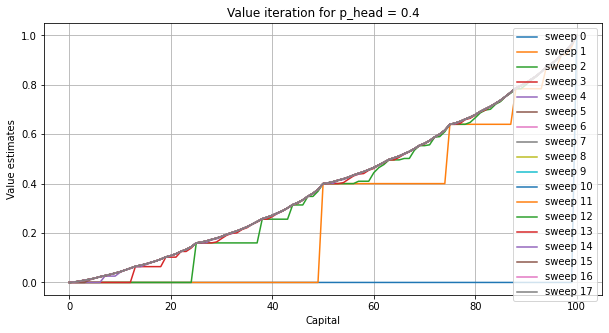

In [39]:
def value_iteration(p_head):
  goal = 100
  states = np.arange(goal + 1)
  #initial values
  state_value = np.zeros(goal + 1)  #V(s) <- 0 for all states except goal
  state_value[goal] = 1.0
  sweeps_history = []
  # value iteration
  while True:
      old_state_value = state_value.copy()   #v <- V(s)
      sweeps_history.append(old_state_value)

      for state in states[1:goal]:
          # get possilbe actions for current state
          actions = range(0, (min(state, (100 - state)))+1 ) 
          action_returns = []
          for action in actions:
              returns = (p_head * (state_value[state + action]) )+ ((1-p_head) * (state_value[state - action] ))     # p * [r + V(s')]
              action_returns.append(returns)
          new_value = max(action_returns)
          state_value[state] = new_value  
      delta = abs(state_value - old_state_value).max()
      if delta < 1e-9:
          sweeps_history.append(state_value)
          break
    
  plt.figure(figsize=(10, 5))
  for sweep, state_value in enumerate(sweeps_history):
      plt.plot(state_value, label='sweep {}'.format(sweep))
  plt.legend()
  plt.grid()
  plt.xlabel('Capital')
  plt.ylabel('Value estimates')
  plt.title("Value iteration for p_head = {}".format(p_head))

  return [state_value,states]

returned_state_value, returned_states = value_iteration(p_head)

**b**) Compute and plot the optimal policy

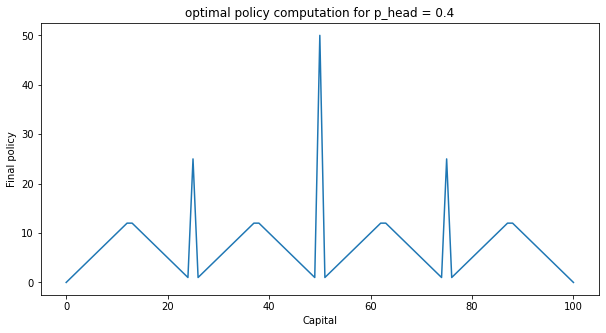

In [40]:
# compute the optimal policy
def compute_plot_policy(state_value,states,p_head):
  policy = np.zeros(goal + 1)
  for state in states[1:goal]:
      actions =range(0, (min(state, (100 - state)))+1 )
      action_returns = []
      for action in actions:
          returns = ((p_head * (state_value[state + action]) )+ ((1-p_head) * (state_value[state - action] )))     # p * [r + V(s')]
          action_returns.append(returns)
      policy[state] = actions[np.argmax(np.round(action_returns[1:], 5)) + 1]

  plt.figure(figsize=(10, 5))
  plt.plot(states, policy)
  plt.xlabel('Capital')
  plt.ylabel('Final policy')
  plt.title("optimal policy computation for p_head = {}".format(p_head))
compute_plot_policy(returned_state_value,returned_states,p_head)

**c**) Re-using your value iteration code provided above, plot the results obtained if $p_{h}=0.25$ and $p_{h}=0.62$.

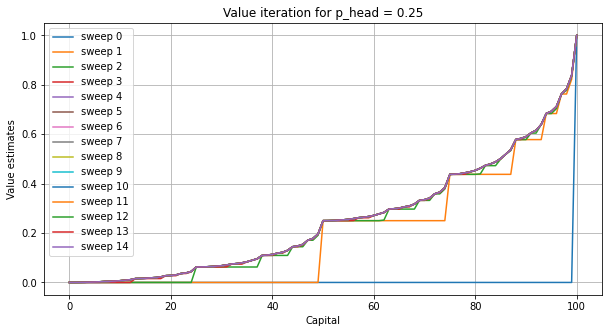

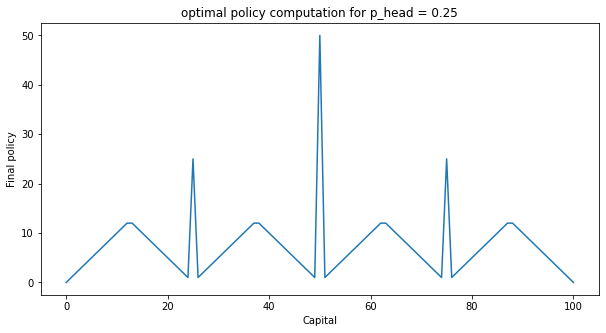

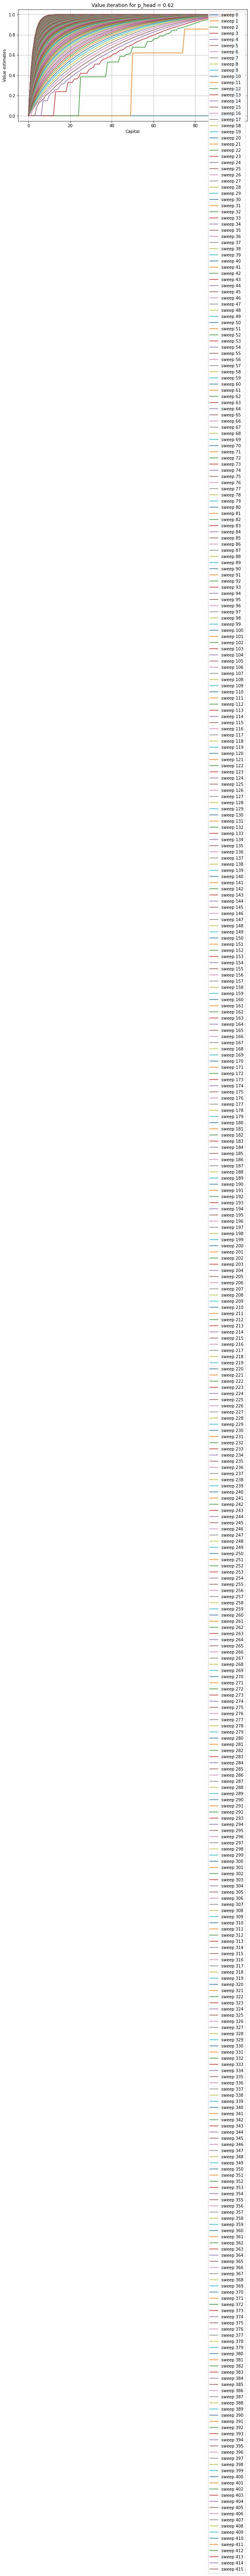

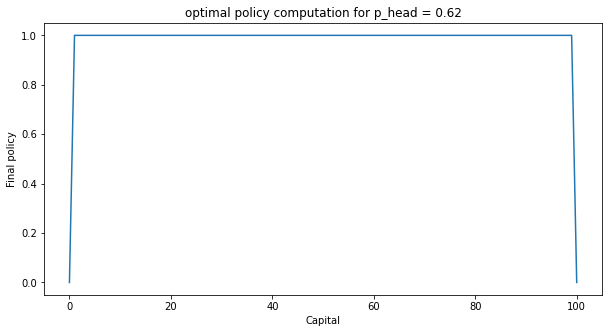

In [41]:
returned =[]
for p in [0.25,0.62]:
  returned_state_value, returned_states = value_iteration(p)
  compute_plot_policy(returned_state_value,returned_states,p)
  returned.append ( (returned_state_value, returned_states,p))

**d**) Compute and plot the corresponding optimal policies

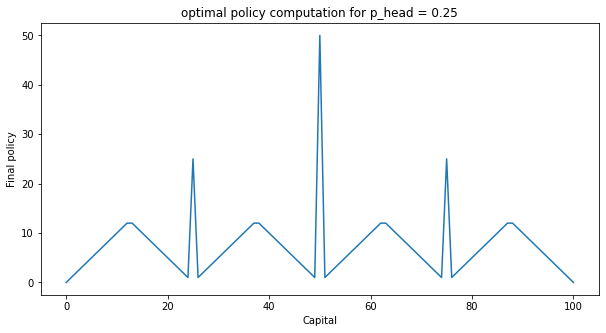

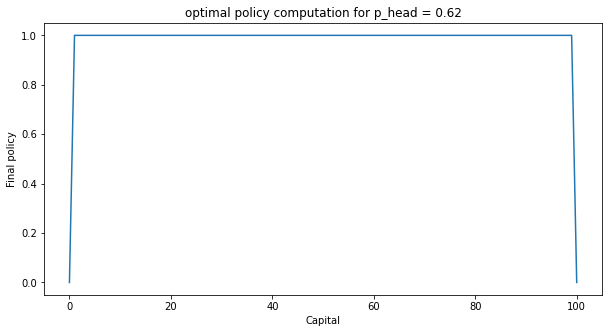

In [42]:
for returned_state_value, returned_states,p in returned :
  compute_plot_policy(returned_state_value,returned_states,p)